# Import the Libraries

In [1]:
import numpy as np
import pandas as pd

import datetime 

import lightgbm as lgb
import optuna.integration.lightgbm as lgbo

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import missingno as msno
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [2]:
# change the Pandas sweetting to display more rows and columns of the dataset
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Load the Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e12/sample_submission.csv')


In [4]:
sample_submission.head()

,id,target
0,414,0.50000
1,415,0.50000
2,416,0.50000
3,417,0.50000
4,418,0.50000


In [5]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      276 non-null    int64  
 1   target  276 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.4 KB


In [6]:
train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.01300,6.19000,443,14.80000,124,1.45000,0
1,1,1.02500,5.40000,703,23.60000,394,4.18000,0
2,2,1.00900,6.13000,371,24.50000,159,9.04000,0
3,3,1.02100,4.91000,442,20.80000,398,6.63000,1
4,4,1.02100,5.53000,874,17.80000,385,2.21000,1


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [8]:
test.head()

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.01700,5.24000,345,11.50000,152,1.16000
1,415,1.02000,5.68000,874,29.00000,385,3.46000
2,416,1.02400,5.36000,698,19.50000,354,13.00000
3,417,1.02000,5.33000,668,25.30000,252,3.46000
4,418,1.01100,5.87000,567,29.00000,457,2.36000


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       276 non-null    int64  
 1   gravity  276 non-null    float64
 2   ph       276 non-null    float64
 3   osmo     276 non-null    int64  
 4   cond     276 non-null    float64
 5   urea     276 non-null    int64  
 6   calc     276 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 15.2 KB


# Preprocessing the data

In [10]:
total_data = pd.concat([train,test], ignore_index=True)
total_data

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.01300,6.19000,443,14.80000,124,1.45000,0.00000
1,1,1.02500,5.40000,703,23.60000,394,4.18000,0.00000
2,2,1.00900,6.13000,371,24.50000,159,9.04000,0.00000
3,3,1.02100,4.91000,442,20.80000,398,6.63000,1.00000
4,4,1.02100,5.53000,874,17.80000,385,2.21000,1.00000
...,...,...,...,...,...,...,...,...
685,685,1.02900,6.27000,853,21.40000,364,7.31000,NaN
686,686,1.01200,5.62000,410,14.00000,195,1.45000,NaN
687,687,1.03100,5.68000,874,29.00000,380,4.49000,NaN
688,688,1.01900,5.47000,543,21.40000,170,1.64000,NaN


# Exploratory Data Analysis

<AxesSubplot:>

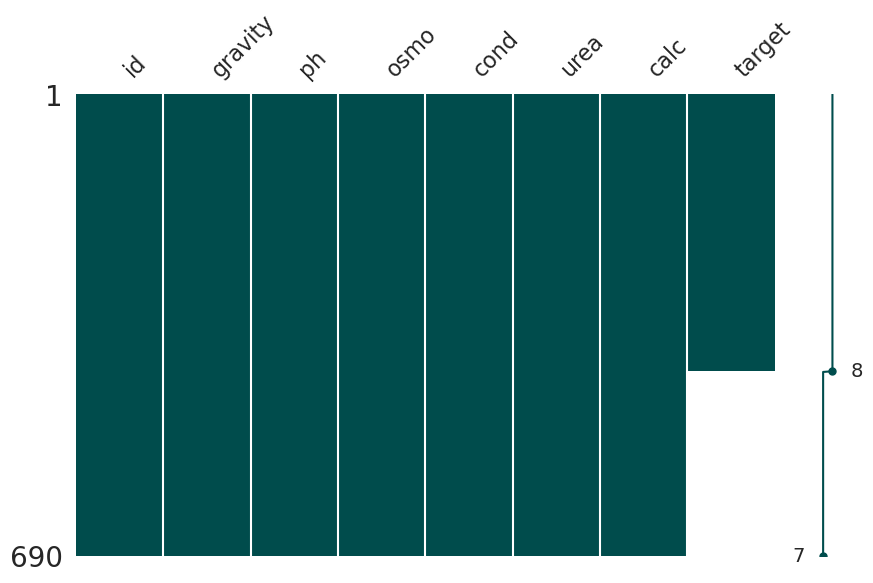

In [11]:
# Find missing data
msno.matrix(df=total_data, figsize=(10,6), color=(0,.3,.3))

In [12]:
total_data.isnull().sum()

id           0
gravity      0
ph           0
osmo         0
cond         0
urea         0
calc         0
target     276
dtype: int64

In [13]:
total_data.drop(columns=['id']).describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
gravity,690.000000,1.018068,0.006631,1.005000,1.012250,1.018000,1.023000,1.040000
ph,690.000000,5.949000,0.628053,4.760000,5.530000,5.730000,6.270000,7.940000
osmo,690.000000,652.884058,235.186535,187.000000,456.000000,668.000000,840.000000,1236.000000
cond,690.000000,21.617391,7.445628,5.100000,15.800000,22.200000,27.600000,38.000000
urea,690.000000,279.588406,135.725311,10.000000,170.000000,282.000000,385.000000,620.000000
calc,690.000000,4.099522,3.164418,0.170000,1.462500,3.160000,5.670000,14.340000
target,414.000000,0.444444,0.497505,0.000000,0.000000,0.000000,1.000000,1.000000


In [14]:
# Independant Variables
feat_ary = [
    'gravity', # Urine density (normal range: 1.005-1.030, the higher the specific gravity, the more problematic)
    'ph',      # ph
    'osmo',    # Osmotic Pressure
    'cond',    # Conductivity
    'urea',    # Urea
    'calc'     # Calcium
]

In [15]:
# Changing the Scale
total_data['gravity'] = total_data['gravity'] * 10
total_data['osmo'] = total_data['osmo'] / 100
total_data['cond'] = total_data['cond'] / 10
total_data['urea'] = total_data['urea'] / 100

In [16]:
total_data.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,10.13000,6.19000,4.43000,1.48000,1.24000,1.45000,0.00000
1,1,10.25000,5.40000,7.03000,2.36000,3.94000,4.18000,0.00000
2,2,10.09000,6.13000,3.71000,2.45000,1.59000,9.04000,0.00000
3,3,10.21000,4.91000,4.42000,2.08000,3.98000,6.63000,1.00000
4,4,10.21000,5.53000,8.74000,1.78000,3.85000,2.21000,1.00000


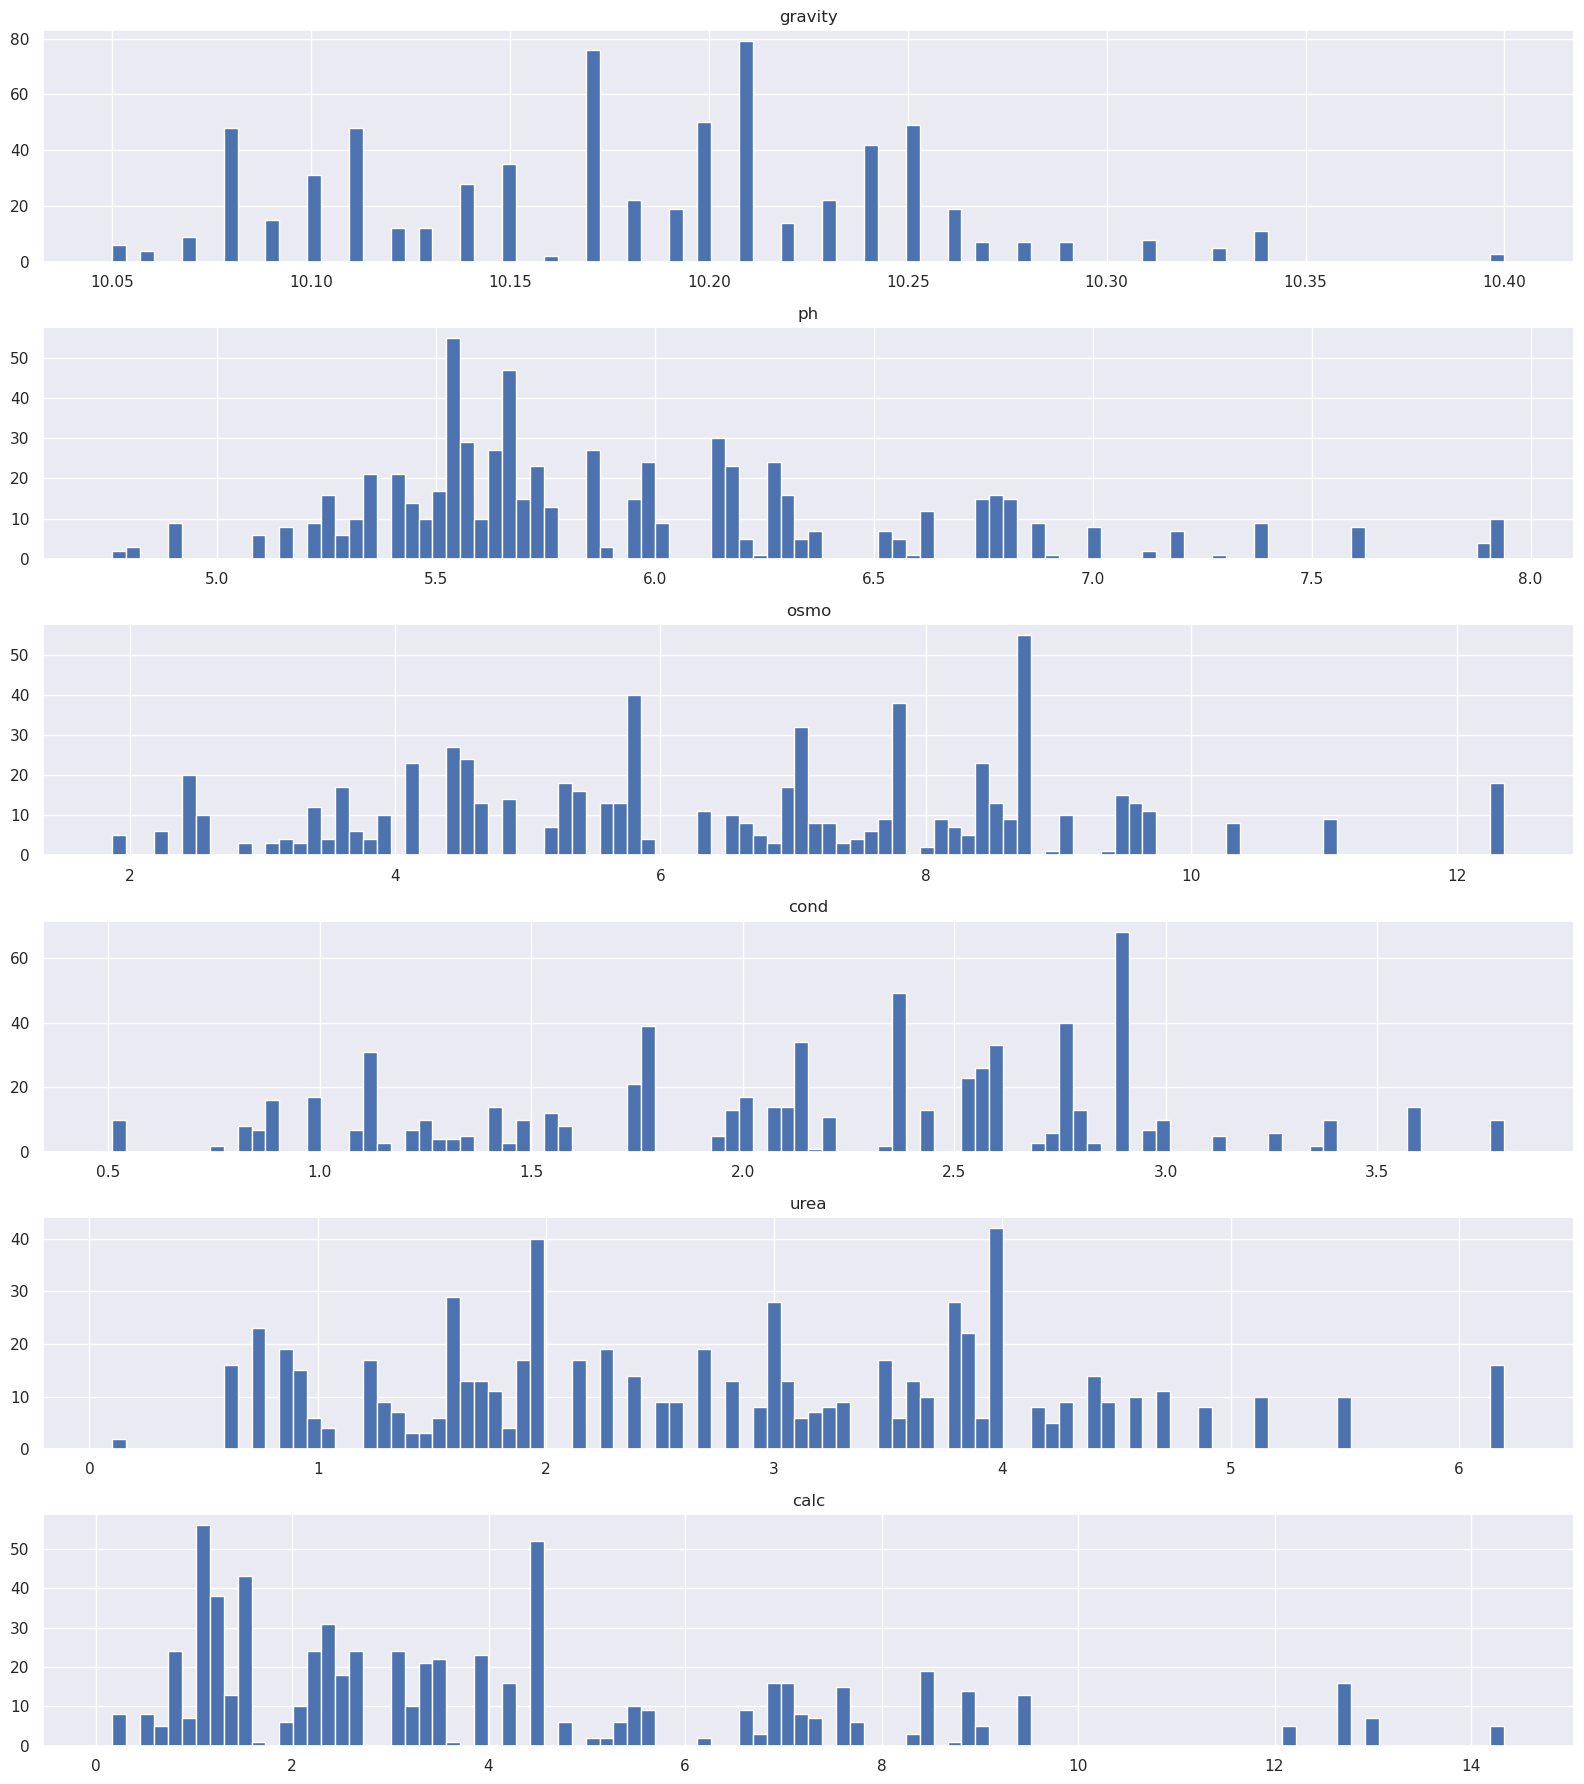

In [17]:
# Visualization of distribution for each feature

figure = plt.figure(figsize=(16, 18))
count = 0
for i in range(len(feat_ary)):
    feat_name = feat_ary[i]
    plt.subplot(6, 1, count+1)
    plt.hist(total_data[feat_name], bins=100)
    plt.title(f'{feat_name}')
    count += 1
figure.tight_layout(h_pad=1.0, w_pad=0.8)
plt.show()

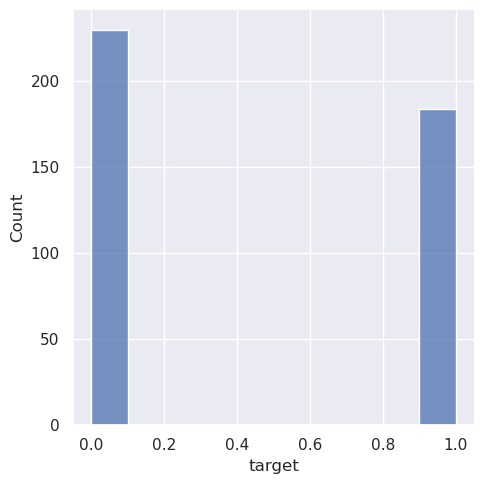

In [18]:
# Histogram of target variable

sns.displot(train['target'], height=5)
plt.show()

In [19]:
total_data.target.value_counts()

0.00000    230
1.00000    184
Name: target, dtype: int64

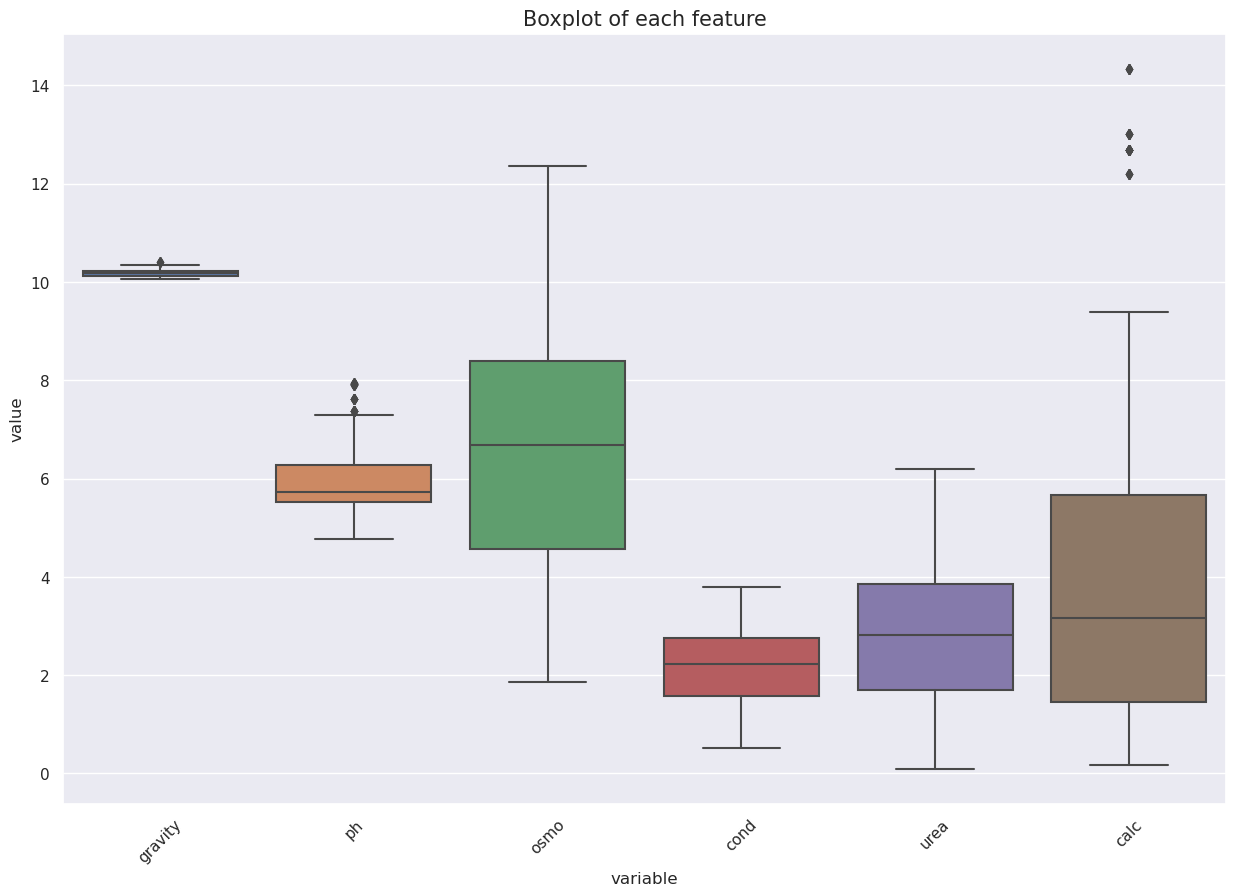

In [20]:
# Boxplot of each feature

df_total_data = pd.DataFrame(data = total_data, columns = feat_ary)
plt.figure(figsize=(15,10)) 
sns.boxplot(x="variable", y="value", data=pd.melt(df_total_data)).set_title('Boxplot of each feature',size=15)
plt.xticks(rotation=45)
plt.show()

In [21]:
# Split the Training and testing data
train = total_data.iloc[train.index[0]:train.index[-1]+1]
test = total_data.iloc[train.index[-1]+1:]

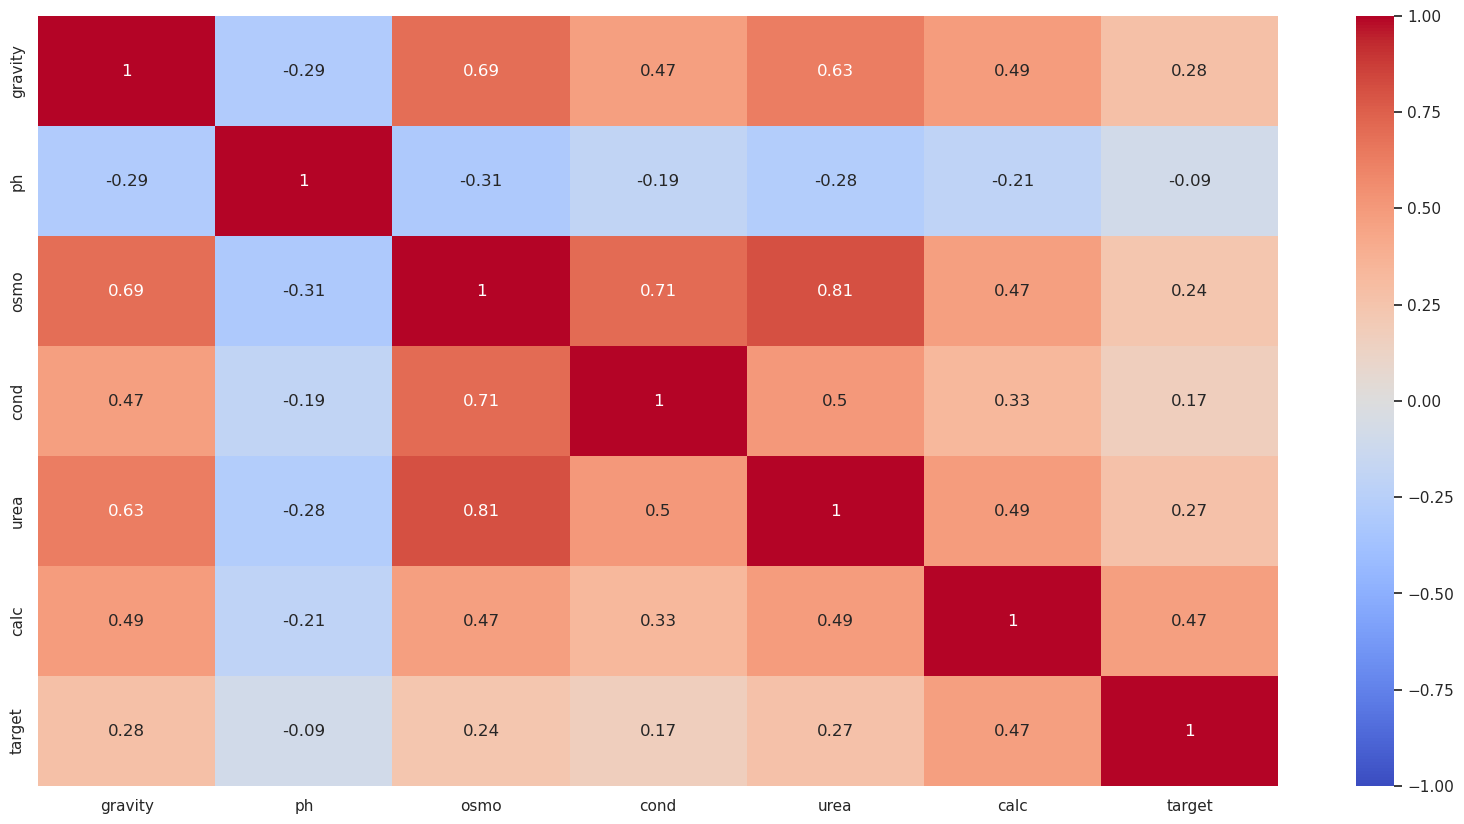

In [22]:
# Correlation Heatmap of train

corr = train.drop(columns=['id']).corr().round(2)
plt.figure(figsize=(20,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm')
plt.show()

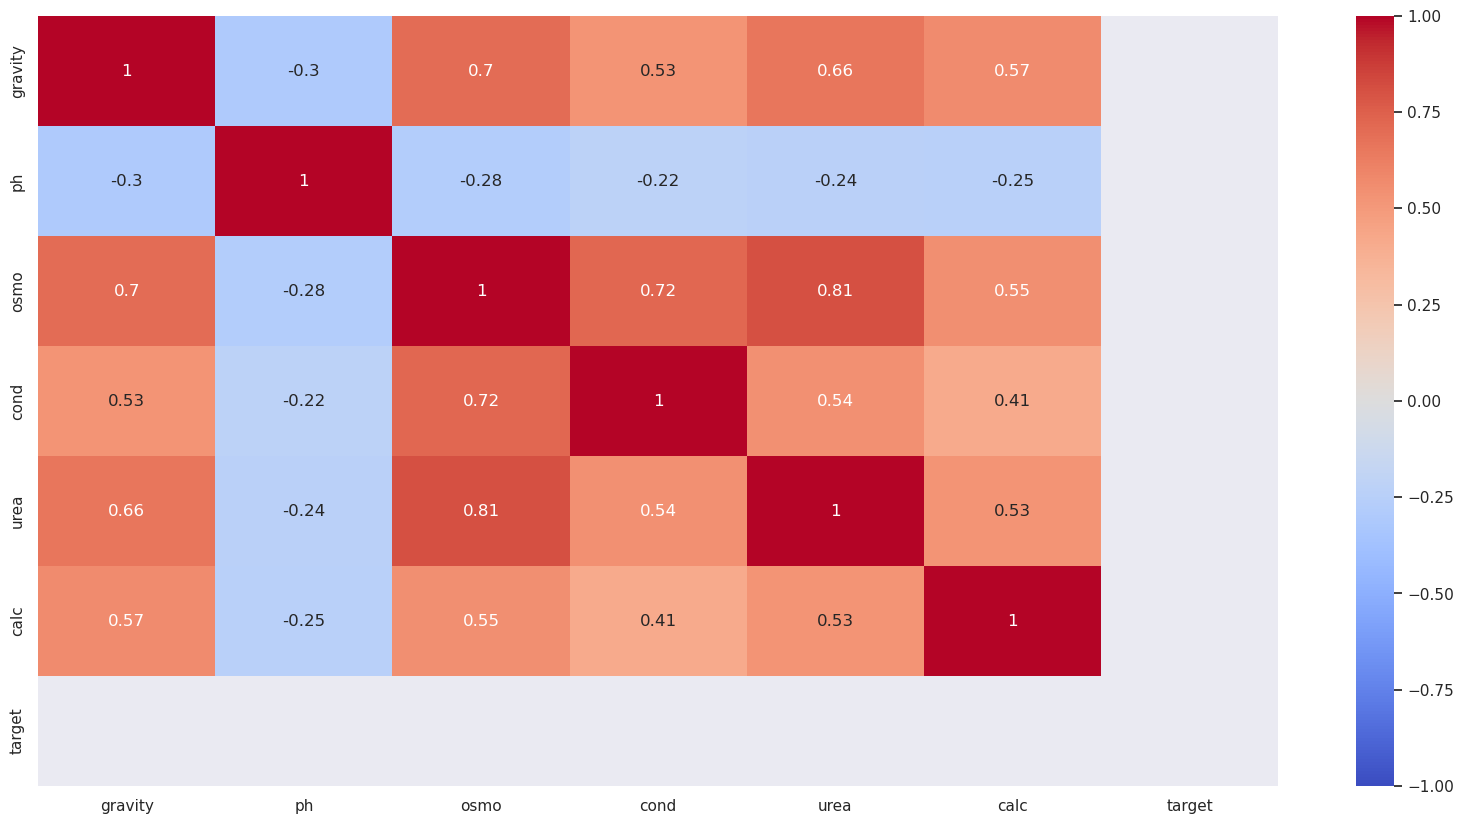

In [23]:
# Correlation Heatmap of train

corr = test.drop(columns=['id']).corr().round(2)
plt.figure(figsize=(20,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm')
plt.show()

In [24]:
# Splitting the target Variable
X = train[feat_ary]
value = train['target']

In [25]:
# optuna
# optuna switch(Using optuna or not)
optuna_switch = 'off' # 'on' or other

# GPU
# usingGPU(Using GPU or not)
usingGPU = 'n' # 'y' or other

In [26]:
# params

objective = "binary"
metric = "binary_logloss" # binary_logloss, binary_error
test_size = 0.2

In [27]:
def tuneParam(X, value, test_size, usingGPU):
    if usingGPU == 'y':
        opt_params = {
            'device': 'gpu',
            "objective" : objective,
            "metric" : metric
        }
    else:
        opt_params = {
            "objective" : objective,
            "metric" : metric
        }

    X_train,X_test,y_train,y_test = train_test_split(
        X,
        value,
        test_size = test_size
    )

    reg_train = lgb.Dataset(
        X_train,
        y_train
    )
    reg_eval = lgb.Dataset(
        X_test,
        y_test,
        reference = reg_train
    )

    opt = lgbo.train(
        opt_params,
        reg_train,
        valid_sets = reg_eval,
        verbose_eval = False,
        num_boost_round = 100,
        early_stopping_rounds = 100
    )
    return opt

In [28]:
%%time

if optuna_switch == 'on':
    opt = tuneParam(X, value, test_size, usingGPU)
    print(opt.params)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


In [29]:
%%time

# modeling

learning_rate = 0.00001 # 0.0001
num_iterations = 1000000 # 100
max_depth = -1
#min_data_in_leaf = 20

X_train, X_test, t_train, t_test = train_test_split(X, value, test_size=test_size, random_state=0)

lgb_train = lgb.Dataset(X_train, t_train)
lgb_eval = lgb.Dataset(X_test, t_test, reference=lgb_train)

if usingGPU == 'y':
    device = 'gpu'
else:
    device = ''

if optuna_switch == 'on':
    params = {
        'device': device,
        'task': 'train',
        'objective': objective,
        'metric': metric,
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_iterations': num_iterations,
        'max_depth': max_depth,
#        'min_data_in_leaf': min_data_in_leaf,
        'feature_pre_filter': opt.params['feature_pre_filter'],
        'lambda_l1': opt.params['lambda_l1'],
        'lambda_l2': opt.params['lambda_l2'],
        'num_leaves': opt.params['num_leaves'],
        'feature_fraction': opt.params['feature_fraction'],
        'bagging_fraction': opt.params['bagging_fraction'],
        'bagging_freq': opt.params['bagging_freq'],
        'min_child_samples': opt.params['min_child_samples'],
        'verbosity': -1
    }
else:
    params = {
        'device': device,
        'task': 'train',
        'objective': objective,
        'metric': metric,
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_iterations': num_iterations,
        'max_depth': max_depth,
#        'min_data_in_leaf': min_data_in_leaf,
        'feature_pre_filter': False,
        'lambda_l1': 8.990302231362418e-06,
        'lambda_l2': 0.07461960145940108,
        'num_leaves': 111,
        'feature_fraction': 0.45199999999999996,
        'bagging_fraction': 0.4911494568215733,
        'bagging_freq': 5,
        'min_child_samples': 10,
        'verbosity': -1
    }

evaluation_results = {}                       # To Save the progress in learning
model = lgb.train(
    params,
    valid_names=['train', 'valid'],           # The name to display in the training progress
    valid_sets=[lgb_train, lgb_eval],         # Validation dataset for model validation
    evals_result=evaluation_results,          # Saving the training progress
    train_set=lgb_train,
    early_stopping_rounds=1000,#100
    verbose_eval=10000
)

Training until validation scores don't improve for 1000 rounds
[10000]	train's binary_logloss: 0.654539	valid's binary_logloss: 0.690817
[20000]	train's binary_logloss: 0.630155	valid's binary_logloss: 0.675006
[30000]	train's binary_logloss: 0.608487	valid's binary_logloss: 0.661457
[40000]	train's binary_logloss: 0.58913	valid's binary_logloss: 0.649914
[50000]	train's binary_logloss: 0.571777	valid's binary_logloss: 0.640231
[60000]	train's binary_logloss: 0.556036	valid's binary_logloss: 0.631952
[70000]	train's binary_logloss: 0.541722	valid's binary_logloss: 0.624971
[80000]	train's binary_logloss: 0.528694	valid's binary_logloss: 0.619039
[90000]	train's binary_logloss: 0.516674	valid's binary_logloss: 0.614013
[100000]	train's binary_logloss: 0.505562	valid's binary_logloss: 0.609735
[110000]	train's binary_logloss: 0.495255	valid's binary_logloss: 0.606186
[120000]	train's binary_logloss: 0.485637	valid's binary_logloss: 0.603294
[130000]	train's binary_logloss: 0.476663	valid

# Validation

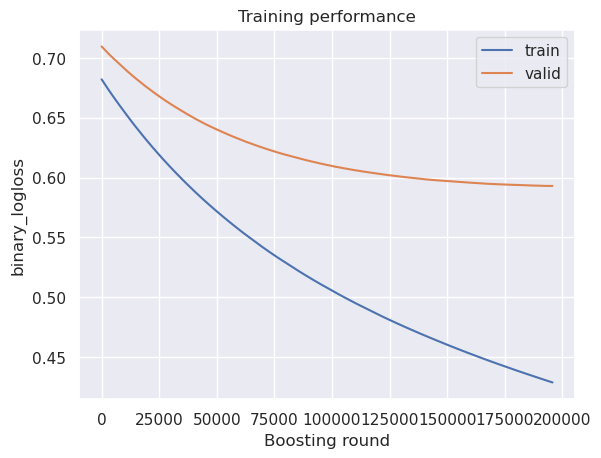

In [30]:
# Learning progress

plt.plot(evaluation_results['train'][metric], label='train')
plt.plot(evaluation_results['valid'][metric], label='valid')
plt.ylabel(metric)
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()


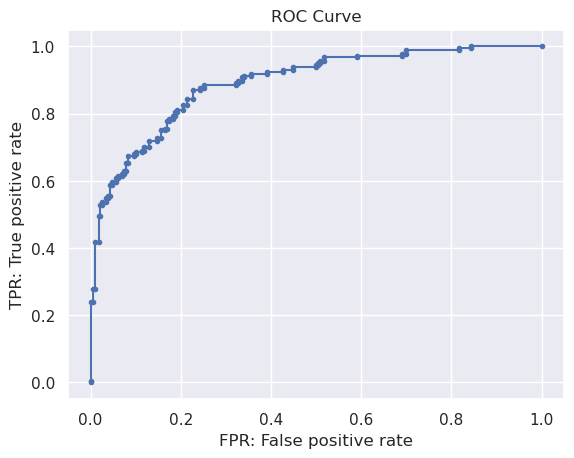

CPU times: user 16.2 s, sys: 0 ns, total: 16.2 s
Wall time: 4.23 s


In [31]:
%%time

# Receiver Operating Characteristics Curve

for_verifi = model.predict(X)
true = train['target']
fpr, tpr, thresholds = roc_curve(true, for_verifi)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.title('ROC Curve')
plt.show()

In [32]:
# Area Under Curve
acc = auc(fpr, tpr)
print("auc : {}".format(acc))

auc : 0.8927457466918713


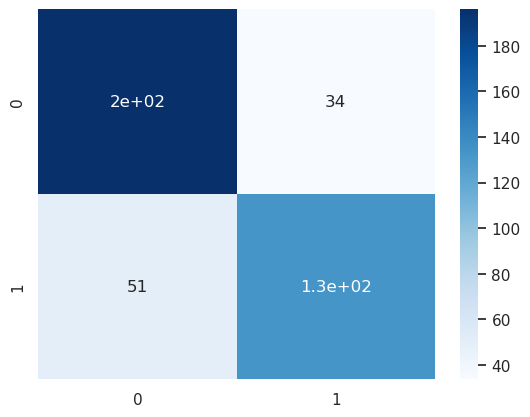

In [33]:
# Confusion matrix

cm = confusion_matrix(train['target'], np.round(for_verifi))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()

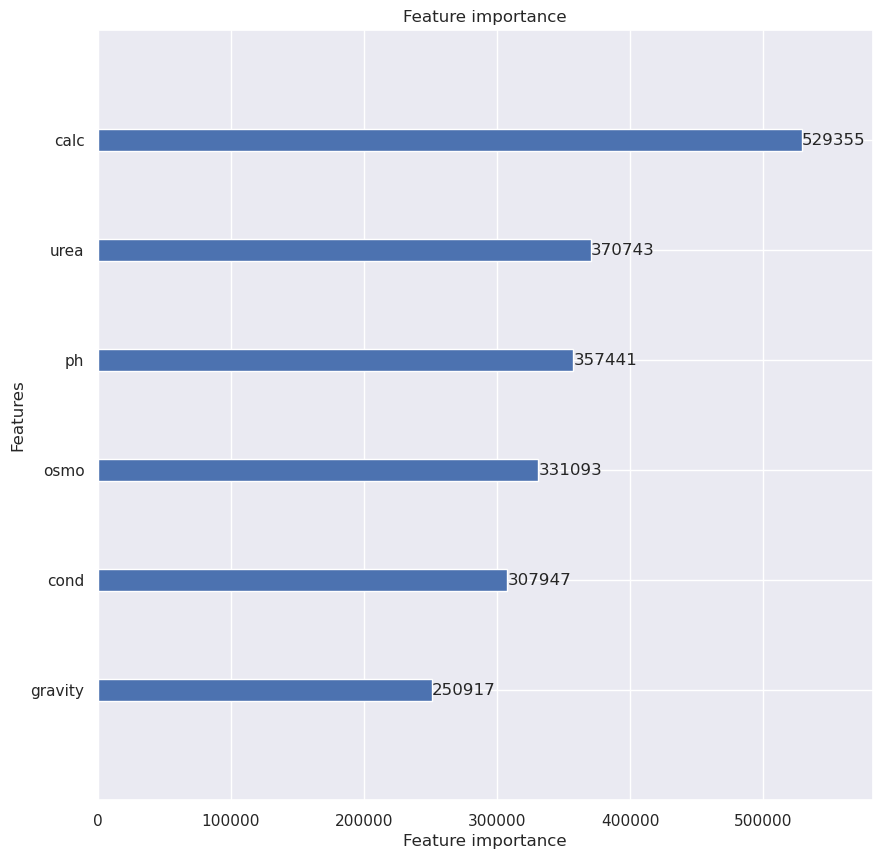

In [34]:
# Feature importance

fig, ax = plt.subplots(figsize=(10, 10))
lgb.plot_importance(model, ax=ax)
plt.show()

# Prediction

In [35]:
%%time

result = model.predict(test[feat_ary])
result

CPU times: user 12.1 s, sys: 0 ns, total: 12.1 s
Wall time: 3.49 s


array([0.12394479, 0.46136217, 0.72467244, 0.4504754 , 0.306591  ,
       0.61655223, 0.3778872 , 0.61732999, 0.24825674, 0.26063494,
       0.27638066, 0.19108895, 0.7527558 , 0.49054139, 0.27661422,
       0.24123911, 0.52429923, 0.283474  , 0.34440369, 0.15738131,
       0.28012203, 0.23496824, 0.28567781, 0.61259438, 0.66856186,
       0.34513831, 0.32718561, 0.10292556, 0.23034662, 0.74701691,
       0.73773772, 0.60211368, 0.54686542, 0.61559783, 0.65632252,
       0.35235069, 0.57230435, 0.65550851, 0.17331082, 0.61271839,
       0.56380685, 0.54305836, 0.79020311, 0.30601698, 0.85449086,
       0.38296334, 0.64777966, 0.45442338, 0.36923495, 0.16007068,
       0.73323558, 0.75352831, 0.36849061, 0.23047261, 0.39832536,
       0.3095396 , 0.6112878 , 0.25985335, 0.54531525, 0.50867158,
       0.62646741, 0.25105476, 0.29399221, 0.10247404, 0.19723223,
       0.72932077, 0.10459714, 0.71816904, 0.26525922, 0.25742022,
       0.17877976, 0.57762529, 0.27502371, 0.51054046, 0.42030

# Submit

In [36]:
sample_submission['target'] = result
sample_submission

,id,target
0,414,0.12394
1,415,0.46136
2,416,0.72467
3,417,0.45048
4,418,0.30659
...,...,...
271,685,0.73608
272,686,0.15542
273,687,0.58944
274,688,0.19769


In [37]:
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)